In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import classification_report

In [3]:
dataset_dir = "D:/workspace/dataset"  
output_dir = "D:/workspace/processed"

os.makedirs(output_dir, exist_ok=True)

In [5]:
import os
import pandas as pd
from glob import glob

# [1] 기본 경로 설정
base_path = r"D:/workspace/dataset/dataset/data/data/Training/source"
vehicle_types = ["big", "middle", "little"]
categories = ["illegal", "normality"]

# [2] 전체 이미지 경로 수집
all_data = []

for vt in vehicle_types:
    for cat in categories:
        folder_path = os.path.join(base_path, vt, cat)
        if not os.path.exists(folder_path):
            continue
        img_files = glob(os.path.join(folder_path, "*.jpg"))
        label = "불법" if cat == "illegal" else "정상"
        for img_path in img_files:
            all_data.append((img_path, label, vt))

# [3] DataFrame으로 저장
df_all = pd.DataFrame(all_data, columns=["image_path", "label", "vehicle_type"])
df_all.to_csv("all.csv", index=False, encoding="utf-8-sig")
print(f"✅ 전체 데이터 CSV 저장 완료! 총 이미지 수: {len(df_all)}장")

✅ 전체 데이터 CSV 저장 완료! 총 이미지 수: 328211장


In [34]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# CSV 파일 로드
df = pd.read_csv("all.csv")  # 전체 이미지 경로와 라벨이 담긴 CSV
target_size = (224, 224)

save_dir = "full_npy_images"
os.makedirs(save_dir, exist_ok=True)

y_labels = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        img = cv2.imdecode(np.fromfile(row['image_path'], dtype=np.uint8), cv2.IMREAD_COLOR)
        if img is None:
            continue

        # 비율 유지하면서 padding 처리
        h, w = img.shape[:2]
        scale = min(target_size[0] / w, target_size[1] / h)
        new_w, new_h = int(w * scale), int(h * scale)
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        result = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
        x_offset = (target_size[0] - new_w) // 2
        y_offset = (target_size[1] - new_h) // 2
        result[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

        # 정규화
        result = result.astype(np.float32) / 255.0

        # 저장
        np.save(os.path.join(save_dir, f"img_{i:05d}.npy"), result)

        # 라벨 처리
        y_labels.append(1 if row['label'] == '불법' else 0)
    except Exception as e:
        print(f"⚠️ {i}번 이미지 오류: {e}")

# 라벨 저장
np.save("y_full.npy", np.array(y_labels, dtype=np.uint8))
print("✅ 전체 데이터 변환 완료. 총 저장된 이미지 수:", len(y_labels))

100%|████████████████████████████████████████████████████████████████| 328211/328211 [2:30:06<00:00, 36.44it/s]

✅ 전체 데이터 변환 완료. 총 저장된 이미지 수: 328210


In [13]:
import os, random, cv2  #새로운 검증용 샘플
import numpy as np
from tqdm import tqdm
from glob import glob

val_base_path = r"D:/workspace/dataset/dataset/data/data/Validation/source"
save_dir = "val_256_images"
os.makedirs(save_dir, exist_ok=True)

vehicle_types = ["big", "middle", "little"]
categories = ["illegal", "normality"]
target_size = (224, 224)

val_image_label_list = []
for vt in vehicle_types:
    for cat in categories:
        folder_path = os.path.join(val_base_path, vt, cat)
        label = 1 if cat == "illegal" else 0
        img_files = glob(os.path.join(folder_path, "*.jpg"))
        val_image_label_list.extend([(p, label) for p in img_files])

# 클래스당 2000장씩 샘플링
illegal = [x for x in val_image_label_list if x[1] == 1]
normal = [x for x in val_image_label_list if x[1] == 0]
random.seed(42)
val_sample = random.sample(illegal, 2000) + random.sample(normal, 2000)
random.shuffle(val_sample)

y_val_sample = []

def resize_with_padding(img, target_size=(224, 224)):
    h, w = img.shape[:2]
    scale = min(target_size[0] / w, target_size[1] / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    result = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
    x_offset = (target_size[0] - new_w) // 2
    y_offset = (target_size[1] - new_h) // 2
    result[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    return result

for i, (path, label) in enumerate(tqdm(val_sample)):
    try:
        img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_COLOR)
        if img is None:
            continue
        resized = resize_with_padding(img)
        resized = resized.astype(np.float32) / 255.0
        np.save(os.path.join(save_dir, f"img_{i:05d}.npy"), resized)
        y_val_sample.append(label)
    except Exception as e:
        print(f"⚠️ {path}: {e}")

np.save("y_val_sample.npy", np.array(y_val_sample))
print("✅ 검증 이미지 저장 완료:", len(y_val_sample))

100%|██████████████████████████████████████████████████████████████████████| 4000/4000 [01:13<00:00, 54.78it/s]

✅ 검증 이미지 저장 완료: 4000


In [38]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.applications import EfficientNetB0
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from keras.utils import Sequence
from keras.callbacks import EarlyStopping

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU 메모리 점진 할당 설정 완료")
    except RuntimeError as e:
        print("❌ GPU 메모리 설정 실패:", e)

# ✅ 1. 커스텀 제너레이터
class FileBasedGenerator(Sequence):
    def __init__(self, x_folder, y_path, batch_size=32, shuffle=True):
        self.x_folder = x_folder
        self.y = np.load(y_path)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.y))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, index):
        batch_ids = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X = [np.load(os.path.join(self.x_folder, f"img_{i:05d}.npy")) for i in batch_ids]
        y = self.y[batch_ids]
        return np.array(X, dtype=np.float32), y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# ✅ 2. 하이퍼파라미터 설정
input_size = 224  # EfficientNetB0의 기본 해상도
dropout_rate = 0.4
loss_func = 'binary_crossentropy'
batch_size = 32
epochs = 15

# ✅ 3. 데이터 로딩
train_gen = FileBasedGenerator("full_npy_images", "y_full.npy", batch_size=batch_size)
val_gen = FileBasedGenerator("val_256_images", "y_val_sample.npy", batch_size=batch_size, shuffle=False)

# ✅ 4. EfficientNetB0 일부 fine-tuning
base_model = EfficientNetB0(include_top=False, input_shape=(input_size, input_size, 3), weights='imagenet')
base_model.trainable = False
for layer in base_model.layers[:-50]:
    layer.trainable = True  # 마지막 20개 레이어만 fine-tuning

# ✅ 5. 전체 모델 구성
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(dropout_rate) if dropout_rate > 0 else tf.keras.layers.Lambda(lambda x: x),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# ✅ 6. 컴파일 및 학습
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss_func, metrics=['accuracy'])

model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[early_stop])

#저장
tf.saved_model.save(model, "exported_model")

# ✅ 7. 평가
y_val = np.load("y_val_sample.npy")
y_pred = model.predict(val_gen) > 0.4
print(classification_report(y_val, y_pred))

✅ GPU 메모리 점진 할당 설정 완료
Epoch 1/15
10257/10257 [==============================] - 2664s 259ms/step - loss: 0.3106 - accuracy: 0.8704 - val_loss: 0.2301 - val_accuracy: 0.9003
Epoch 2/15
10257/10257 [==============================] - 2645s 258ms/step - loss: 0.2462 - accuracy: 0.9005 - val_loss: 0.2659 - val_accuracy: 0.8815
Epoch 3/15
10257/10257 [==============================] - 2571s 251ms/step - loss: 0.2266 - accuracy: 0.9093 - val_loss: 0.3261 - val_accuracy: 0.8680
Epoch 4/15
10257/10257 [==============================] - 2667s 260ms/step - loss: 0.2141 - accuracy: 0.9150 - val_loss: 0.2857 - val_accuracy: 0.8860
Epoch 5/15
10257/10257 [==============================] - 2762s 269ms/step - loss: 0.2062 - accuracy: 0.9183 - val_loss: 0.3343 - val_accuracy: 0.8748
Epoch 6/15
10257/10257 [==============================] - 2441s 238ms/step - loss: 0.2000 - accuracy: 0.9209 - val_loss: 0.3104 - val_accuracy: 0.8875


INFO:tensorflow:Assets written to: exported_model\assets


INFO:tensorflow:Assets written to: exported_model\assets


125/125 [==============================] - 7s 46ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2000
           1       0.89      0.92      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



In [35]:
import tensorflow as tf
print("버전:", tf.__version__)
print("GPU 목록:", tf.config.list_physical_devices('GPU'))

버전: 2.10.0
GPU 목록: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # 로그 최대 출력

import tensorflow as tf
from tensorflow.python.client import device_lib

print("버전:", tf.__version__)
print("GPU 목록:", tf.config.list_physical_devices('GPU'))
print("[전체 디바이스]")
print(device_lib.list_local_devices())

버전: 2.10.0
GPU 목록: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[전체 디바이스]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6921810042332666270
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4243587072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17484032564323708783
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:26:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [11]:
import numpy as np
print(np.__version__)

1.26.4


In [2]:
import tensorflow as tf
print("TF 버전:", tf.__version__)

# 디바이스 출력
print("GPU 디바이스 목록:", tf.config.list_physical_devices('GPU'))

# 상세 디바이스 로그
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

TF 버전: 2.10.0
GPU 디바이스 목록: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15681411329410121091
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4243587072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8147746258767123930
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:26:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [1]:
import tensorflow as tf
print("CUDA 지원:", tf.test.is_built_with_cuda())
print("cuDNN 지원:", tf.test.is_built_with_gpu_support())

CUDA 지원: True
cuDNN 지원: True


In [5]:
import os
import numpy as np
import cv2
from tqdm import tqdm

# ✅ 설정: 경로 및 사이즈
root_dir = r"D:\workspace\dataset\dataset\data\data\Validation\source"
target_size = (224, 224)  # 모델 입력에 맞춰 리사이즈
output_dir = r"D:\workspace\full_val_npy"
os.makedirs(output_dir, exist_ok=True)

# ✅ 클래스별 정보
classes = {
    'illegal': 1,
    'normality': 0
}

# ✅ 차종별 서브디렉토리 순회
count = 0
X = []
y = []

for car_size in ['big', 'middle', 'little']:
    for label_type in ['illegal', 'normality']:
        folder = os.path.join(root_dir, car_size, label_type)
        for filename in tqdm(os.listdir(folder), desc=f"{car_size}/{label_type}"):
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, target_size)
            img = img.astype(np.float32) / 255.0
            np.save(os.path.join(output_dir, f"img_{count:05d}.npy"), img)
            y.append(classes[label_type])
            count += 1

# ✅ 라벨 저장
np.save(os.path.join(output_dir, "y_full.npy"), np.array(y))
print(f"✅ 변환 완료: 총 {count}개 이미지 저장")

little/normality: 100%|████████████████████████████████████████████████████| 8229/8229 [02:41<00:00, 50.85it/s]

✅ 변환 완료: 총 41025개 이미지 저장


              precision    recall  f1-score   support

           0     0.7327    0.8228    0.7751     20560
           1     0.7968    0.6984    0.7444     20465

    accuracy                         0.7607     41025
   macro avg     0.7648    0.7606    0.7597     41025
weighted avg     0.7647    0.7607    0.7598     41025



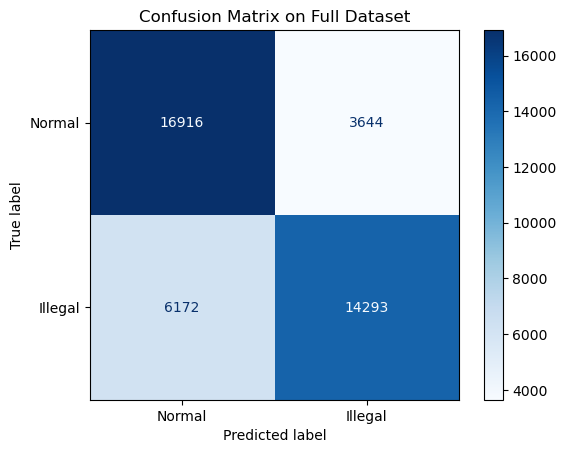

In [11]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.utils import Sequence

# ✅ 경로 설정
data_dir = r"D:\workspace\full_val_npy"
saved_model_path = "exported_model"  # SavedModel 디렉토리
batch_size = 32
input_size = 224

# ✅ 1. 커스텀 제너레이터
class NPYLoader(Sequence):
    def __init__(self, data_dir, y_path, batch_size=32):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.y = np.load(y_path)
        self.total = len(self.y)

    def __len__(self):
        return int(np.ceil(self.total / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.total))
        X = [np.load(os.path.join(self.data_dir, f"img_{i:05d}.npy")) for i in batch_ids]
        X = np.array(X, dtype=np.float32)
        return X, self.y[list(batch_ids)]

# ✅ 2. 데이터 로딩
val_gen = NPYLoader(data_dir, os.path.join(data_dir, "y_full.npy"), batch_size=batch_size)
y_true = np.load(os.path.join(data_dir, "y_full.npy"))

# ✅ 3. 모델 로드 (SavedModel 형식)
model = tf.saved_model.load(saved_model_path)
infer = model.signatures["serving_default"]  # 추론 함수

# ✅ 4. 예측
y_pred_list = []
for x_batch, _ in val_gen:
    preds = infer(tf.convert_to_tensor(x_batch))['dense_53']  # 출력 레이어 이름
    y_pred_list.extend((preds.numpy().flatten() > 0.5).astype(int))

y_pred = np.array(y_pred_list)

# ✅ 5. 평가 출력
print(classification_report(y_true, y_pred, digits=4))

# ✅ 6. Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Illegal"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix on Full Dataset")
plt.show()


In [8]:
print(infer.structured_outputs)

{'dense_53': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense_53')}


In [37]:
import os
import numpy as np

folder = "full_npy_images"
y = np.load("y_full.npy")
missing = []

for i in range(len(y)):
    path = os.path.join(folder, f"img_{i:05d}.npy")
    if not os.path.exists(path):
        missing.append(i)

print(f"❌ 누락된 파일 수: {len(missing)}개")
print("예시:", missing[:10])

❌ 누락된 파일 수: 1개
예시: [12543]


📊 [전체 평가 결과]
              precision    recall  f1-score   support

           0     0.7327    0.8228    0.7751     20560
           1     0.7968    0.6984    0.7444     20465

    accuracy                         0.7607     41025
   macro avg     0.7648    0.7606    0.7597     41025
weighted avg     0.7647    0.7607    0.7598     41025



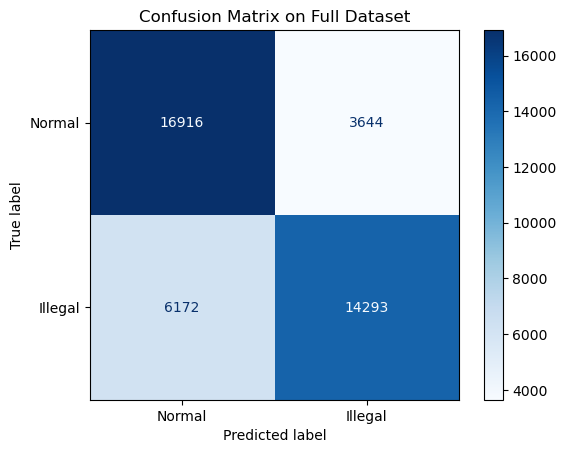


🚗 [차량 크기별 정확도]
 - Little: 0.6876
 - Middle: 0.8645
 - Big: 0.7634


In [14]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from keras.utils import Sequence

# ✅ 경로 설정
data_dir = r"D:\workspace\full_val_npy"
saved_model_path = "exported_model"  # SavedModel 디렉토리
batch_size = 32
input_size = 224

# ✅ 1. 커스텀 제너레이터
class NPYLoader(Sequence):
    def __init__(self, data_dir, y_path, batch_size=32):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.y = np.load(y_path)
        self.total = len(self.y)

    def __len__(self):
        return int(np.ceil(self.total / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = range(idx * self.batch_size, min((idx + 1) * self.batch_size, self.total))
        X = [np.load(os.path.join(self.data_dir, f"img_{i:05d}.npy")) for i in batch_ids]
        X = np.array(X, dtype=np.float32)
        return X, self.y[list(batch_ids)]

# ✅ 2. 데이터 로딩
y_true = np.load(os.path.join(data_dir, "y_full.npy"))
val_gen = NPYLoader(data_dir, os.path.join(data_dir, "y_full.npy"), batch_size=batch_size)

# 차량 크기 정보 (각 샘플의 'big', 'middle', 'little')
type_list = np.load(os.path.join(data_dir, "type_full.npy"))  # ← 반드시 존재해야 함

# ✅ 3. 모델 로드
model = tf.saved_model.load(saved_model_path)
infer = model.signatures["serving_default"]  # 추론 함수

# ✅ 4. 예측
y_pred_list = []
for x_batch, _ in val_gen:
    preds = infer(tf.convert_to_tensor(x_batch))['dense_53']
    y_pred_list.extend((preds.numpy().flatten() > 0.5).astype(int))

y_pred = np.array(y_pred_list)

# ✅ 5. 전체 평가 출력
print("📊 [전체 평가 결과]")
print(classification_report(y_true, y_pred, digits=4))

# ✅ 6. Confusion Matrix 시각화
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Illegal"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix on Full Dataset")
plt.show()

# ✅ 7. 차량 크기별 정확도 계산
print("\n🚗 [차량 크기별 정확도]")
# 차량 종류 숫자 매핑
vehicle_type_names = {0: "Big", 1: "Middle", 2: "Little"}

# 정확도 계산
for v_id in [2, 1, 0]:  # Little → Middle → Big 순서
    idxs = np.where(type_list == v_id)[0]
    if len(idxs) == 0:
        acc = float('nan')
    else:
        acc = (y_true[idxs] == y_pred[idxs]).mean()
    print(f" - {vehicle_type_names[v_id]}: {acc:.4f}")

In [12]:
import os
import numpy as np
from glob import glob

# 경로 설정
base_dir = r"D:\workspace\dataset\dataset\data\data\Validation\source"
vehicle_types = ["big", "middle", "little"]
categories = ["illegal", "normality"]

# 이미지별 vehicle type 저장용 리스트
type_labels = []

# 순차적으로 이미지 경로 순서에 맞게 type label 할당
for vt in vehicle_types:
    for cat in categories:
        folder = os.path.join(base_dir, vt, cat)
        if not os.path.exists(folder):
            continue
        img_files = sorted(glob(os.path.join(folder, "*.jpg")))
        label_id = vehicle_types.index(vt)  # 0=big, 1=middle, 2=little
        type_labels.extend([label_id] * len(img_files))

# numpy로 저장
type_labels = np.array(type_labels, dtype=np.uint8)
save_path = r"D:\workspace\full_val_npy\type_full.npy"
np.save(save_path, type_labels)

print("✅ 저장 완료:", save_path)
print("샘플 수:", len(type_labels))
print("클래스별 개수:", np.bincount(type_labels))

✅ 저장 완료: D:\workspace\full_val_npy\type_full.npy
샘플 수: 41025
클래스별 개수: [ 9447 12919 18659]
